In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, issparse
from scipy.sparse.linalg import norm as spnorm
import pickle
import sklearn
from scipy import sparse
import nimfa
import seaborn as sns

%matplotlib inline

/Users/user/anaconda3/envs/python2_7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
%%time
df = pd.read_csv('/Users/user/Documents/Medicare_Provider_Util_Payment_PUF_CY2013/Medicare_Provider_Util_Payment_PUF_CY2013.txt', sep= '\t')

<string>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 2s, sys: 11.7 s, total: 1min 14s
Wall time: 1min 26s


In [3]:
#Clean up first row of the data
df = df[1:]
np.shape(df)

(9287876, 28)

In [4]:
%%time
row_name = 'NPI'
col_name = 'HCPCS_CODE'
measure = 'AVERAGE_SUBMITTED_CHRG_AMT'
# filters: averages are calculated by NPI, HCPCS_CODE and PLACE_OF_SERVICE
# so need to fix PLACE_OF_SERVICE to not be forced to average averages.
# The rest of the filters are up to you.
filters = (df.PLACE_OF_SERVICE == 'F')
filters &= (df.NPPES_ENTITY_CODE == 'O')
filters &= (df.NPPES_PROVIDER_COUNTRY == 'US')
# data = df[filters][[row_name, col_name, measure]].dropna().set_index([row_name, col_name])
data = df[filters].dropna(subset=[measure]).groupby([row_name, col_name])[measure].max()
idx_row = data.index.names.index(row_name)
idx_col = data.index.names.index(col_name)
M = coo_matrix((data.values,
                (data.index.labels[idx_row], data.index.labels[idx_col])),
               shape=[len(data.index.levels[idx_row]), len(data.index.levels[idx_col])]).astype(float)
print(M.shape)

(14822, 1376)
CPU times: user 3.69 s, sys: 910 ms, total: 4.6 s
Wall time: 5.03 s


In [5]:
def reconstruction_error(M, WH):
    """
    This function computes the relative error of a sparse matrix. By concept, this computation is almost the same with
    computing the reconstruction error of the factor matrices formed using python non-negative matrix factorization
    
    Accepts
    -------
    M  : array-like
    WH : the product of the loading matrix W and the coefficient matrix H
    
    Returns
    -------
    a float-value corresponding to the reconstruction error
    """
    
    nonzero_row, nonzero_col = M.nonzero()
    orig = M.todense()[nonzero_row, nonzero_col]
    reconstructed = WH[nonzero_row, nonzero_col]
    
    return np.linalg.norm(orig - reconstructed)

In [6]:
sepnmf = nimfa.SepNmf(M.todense(), rank=50, n_run = 10, selection='xray', compression='qr')
fit = sepnmf()

In [7]:
H = np.array(fit.fit.H)

In [8]:
W = np.array(fit.fit.W)

In [9]:
np.where(W < 0)

(array([], dtype=int64), array([], dtype=int64))

In [10]:
np.all(W >= 0)

True

In [11]:
np.all(H >= 0)

True

In [12]:
np.shape(H)

(50, 1376)

In [13]:
np.shape(W)

(14822, 50)

In [14]:
WH = np.dot(W,H)

# Quality Check

In [15]:
np.linalg.norm(M - WH)/np.linalg.norm(M.todense())

0.90168217042025933

In [15]:
np.linalg.norm(M.todense())

1228035.0817721039

In [16]:
np.max(fit.summary()['residuals'])

74358.653846000001

In [17]:
np.min(fit.summary()['residuals'])

-31528.309665291265

In [18]:
np.mean(fit.summary()['residuals'])

4.8582150910899768

# Test for Interpretability

In [19]:
_scales = H.T.sum(axis=0)
_H = H.T / _scales
_sorted_cols = np.argsort(_H.argmax(axis=0))
_H = _H[:, _sorted_cols]

/Users/user/anaconda3/envs/python2_7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [20]:
_H.shape

(1376, 300)

# Visualization of H and W Matrices

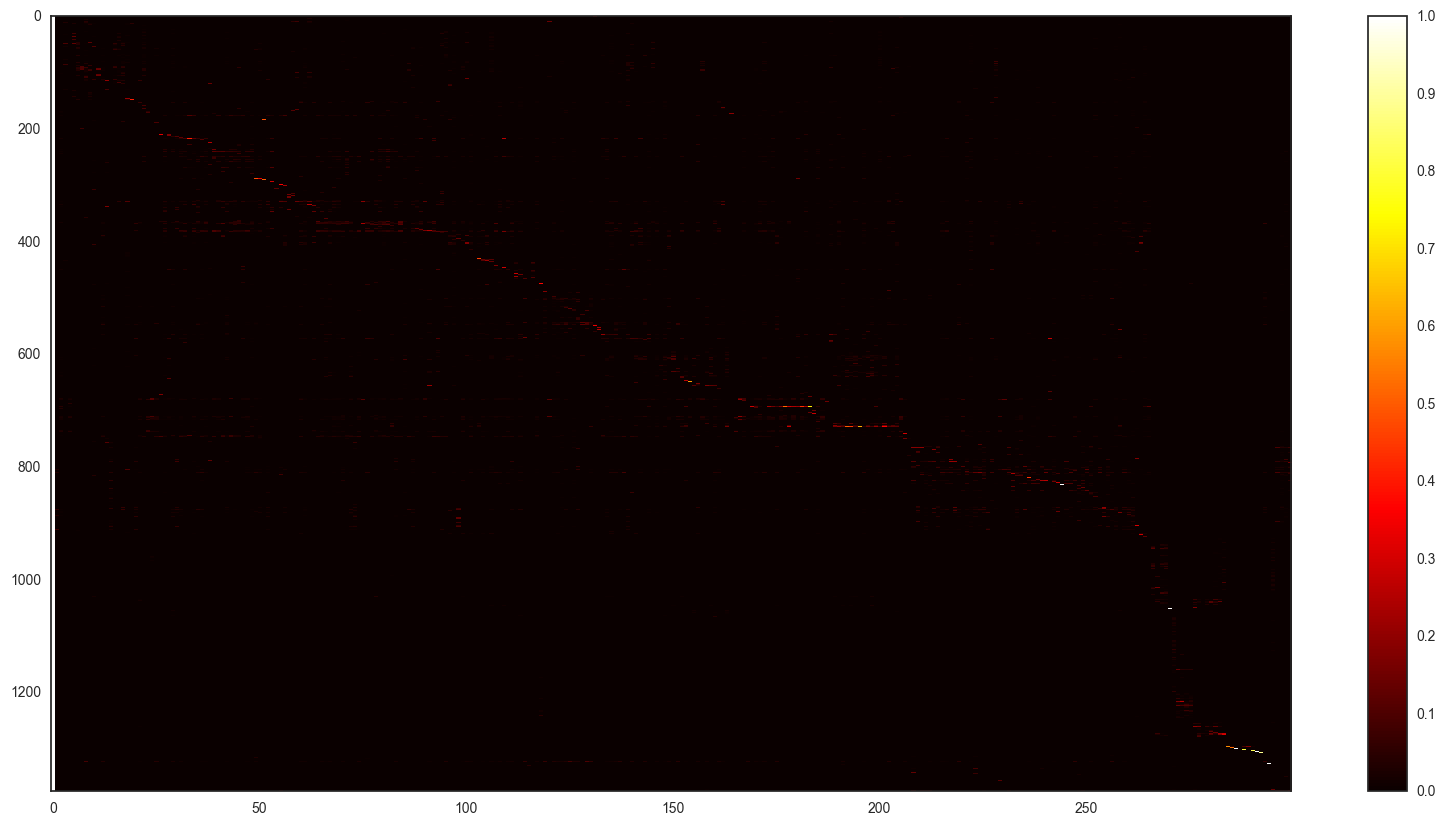

In [21]:
with sns.axes_style("white"):
    plt.figure(figsize=(20, 10))
    plt.imshow(_H, aspect='auto', interpolation='nearest', cmap='hot')#, vmax=0.005)
    plt.colorbar()

In [22]:
_W = W * _scales
_W = _W[:, _sorted_cols]

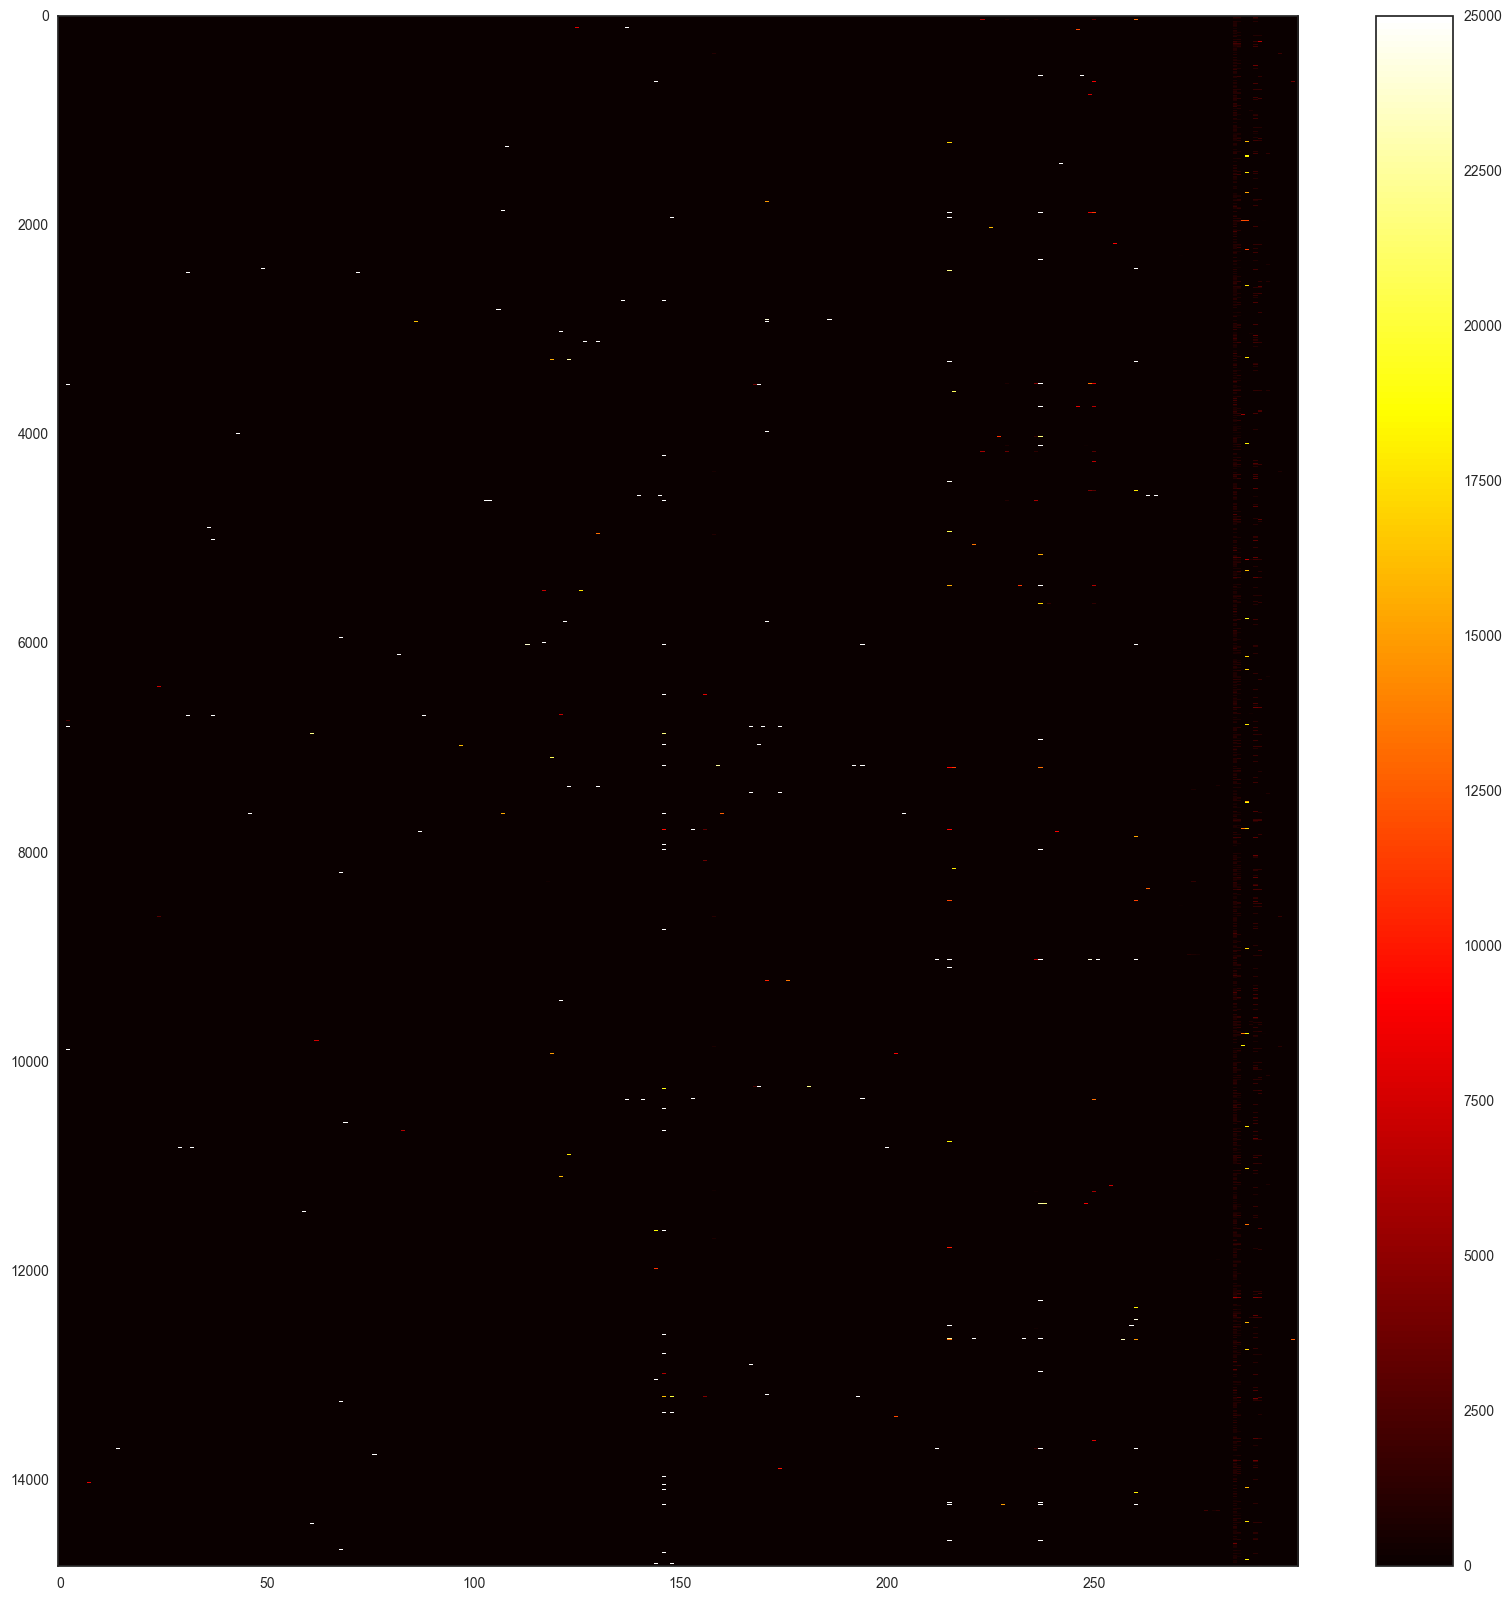

In [23]:
with sns.axes_style("white"):
    plt.figure(figsize=(20, 20))
    plt.imshow(_W, aspect='auto', interpolation='nearest', cmap='hot', vmax=25000)
    plt.colorbar()

# Clustering of Providers 

In [24]:
from sklearn.cluster import KMeans

In [25]:
%%time
kmeans = KMeans(n_clusters=20,random_state=15)
kmeans.fit(_W)
print('number of iterations: {} ({:.2%} of max)'.format(kmeans.n_iter_, kmeans.n_iter_ / kmeans.max_iter))

number of iterations: 7 (0.00% of max)
CPU times: user 5.55 s, sys: 416 ms, total: 5.97 s
Wall time: 3.2 s


In [26]:
clusters = pd.Series(kmeans.predict(_W))
mapper = pd.Series(np.arange(kmeans.n_clusters), index=clusters.value_counts().index)
clusters = mapper[clusters]
clusters.value_counts()

0     14072
1       245
2       154
3       113
4        63
5        47
6        30
7        24
8        17
9        16
10       12
12        7
11        7
13        6
14        2
16        2
15        2
19        1
18        1
17        1
dtype: int64

/Users/user/anaconda3/envs/python2_7/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/user/anaconda3/envs/python2_7/lib/python2.7/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


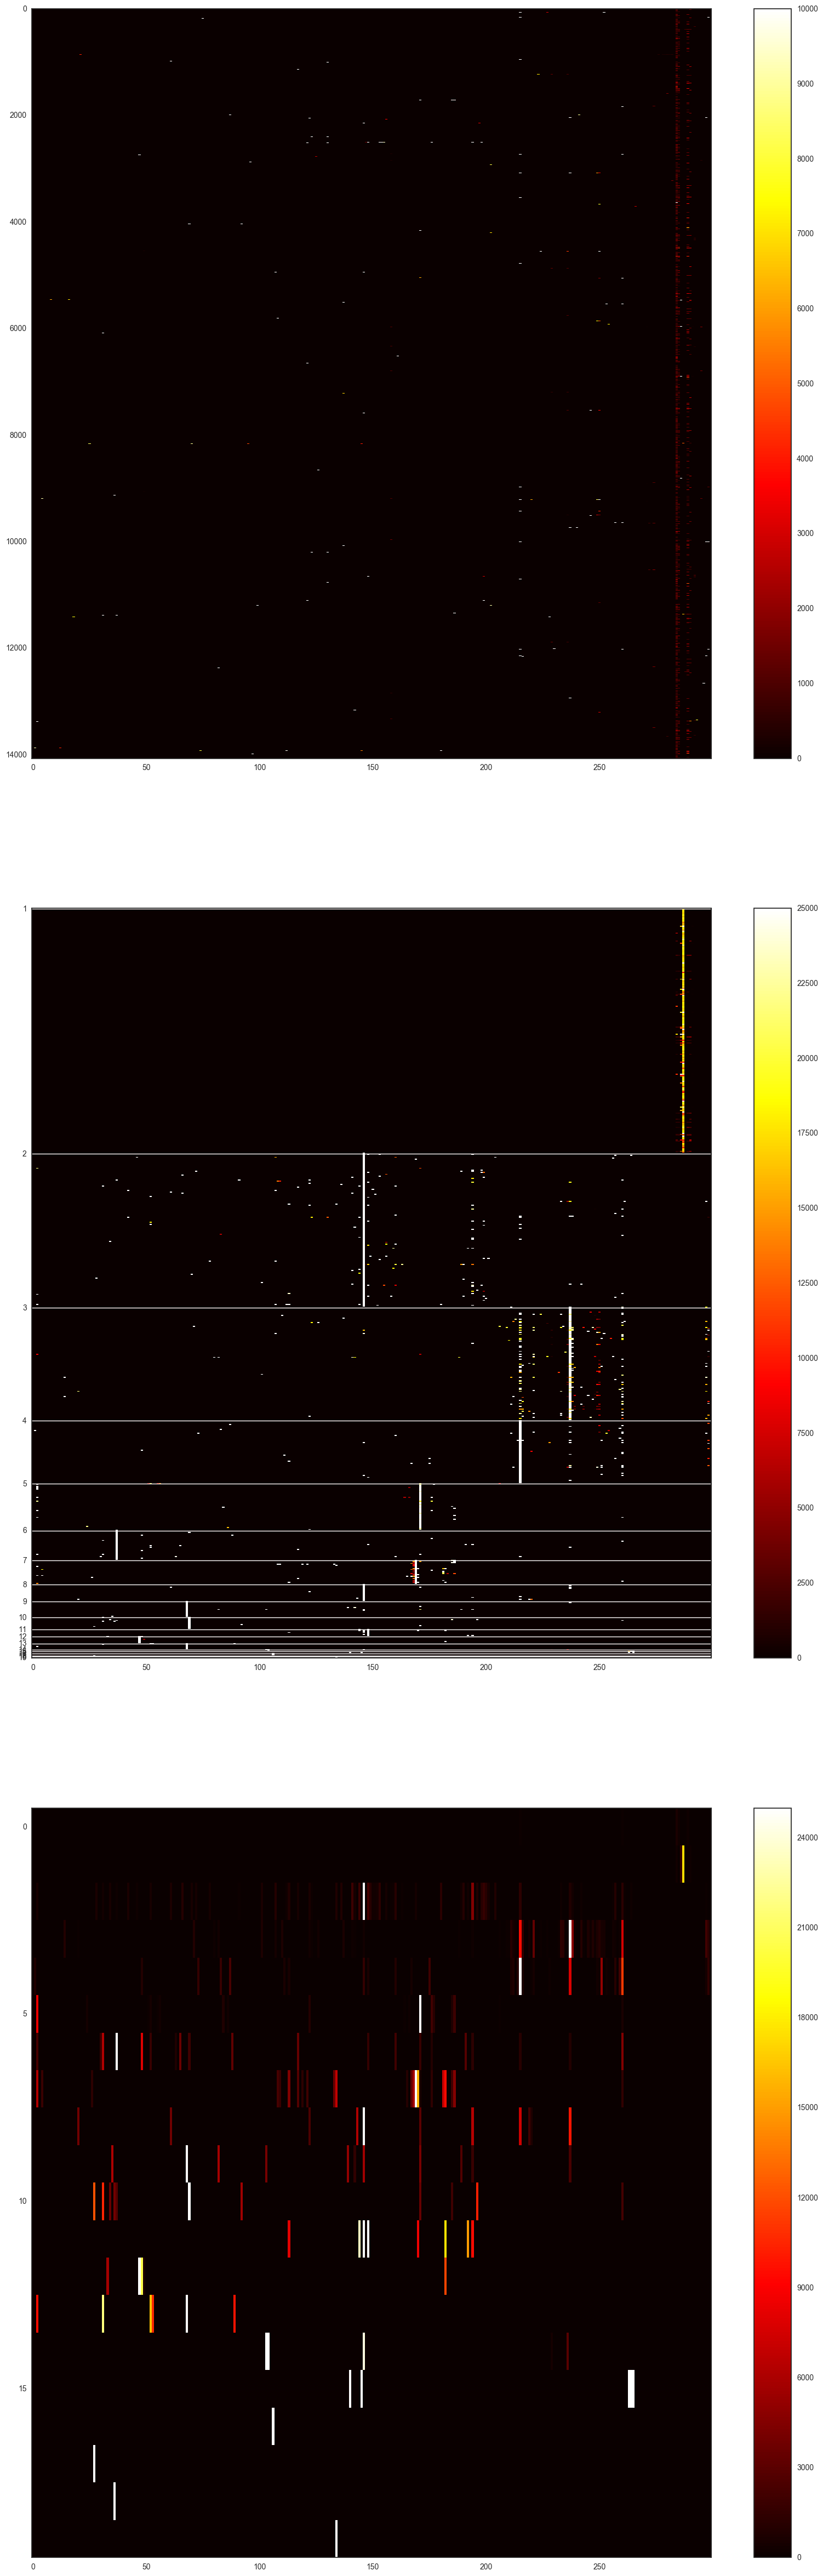

In [27]:
_ytickseries = clusters.value_counts().sort_index().cumsum().shift().fillna(0)
with sns.axes_style("white"):
    plt.figure(figsize=(20, 60))

    plt.subplot(3, 1, 1)
    plt.imshow(_W[clusters.argsort().values[:_ytickseries.ix[1]]],
               aspect='auto', interpolation='nearest', cmap='hot', vmax=10000)
    plt.colorbar()
    
    plt.subplot(3, 1, 2)
    plt.imshow(_W[clusters.argsort().values[_ytickseries.ix[1]:]],
               aspect='auto', interpolation='nearest', cmap='hot', vmax=25000)
    ax = plt.gca()
    ax.set_yticks(_ytickseries.values[1:] - _ytickseries.values[1])
    ax.set_yticklabels(_ytickseries.index[1:])
    ax.grid(True, axis='y', color='w', alpha=1, linewidth=1)
    plt.colorbar()

    plt.subplot(3, 1, 3)    
    plt.imshow(kmeans.cluster_centers_[mapper.index],
               aspect='auto', interpolation='nearest', cmap='hot', vmax=25000)
    plt.colorbar()        

# Print top factors in each cluster

In [28]:
code_to_desc = df.groupby(['HCPCS_CODE', 'HCPCS_DESCRIPTION']).size()\
    .reset_index().drop(0, 1).set_index('HCPCS_CODE')['HCPCS_DESCRIPTION']

In [29]:
pd.set_option('display.max_colwidth', 80)

### Score is fraction of dollar spent on each procedure

In [30]:
for i, _idx_factors in enumerate(kmeans.cluster_centers_[mapper.index].argsort(axis=1)[:, ::-1][:, :3]):
    print('*' * 30 + '{:^20}'.format('cluster {}'.format(i)) + '*' * 30)
    print('size {}'.format(clusters.value_counts()[i]))
    print('')
    for _idx_factor in _idx_factors:
        _idx_code = _H[:, _idx_factor].argsort()[::-1]
        _scores = _H[_idx_code, _idx_factor]
        _lim = np.where(_scores.cumsum() > 0.95)[0][0] + 1
        _s = code_to_desc[data.index.levels[idx_col][_idx_code[:_lim]]]
        _s = pd.concat((_s,
                        pd.Series(_scores[:_lim], index=_s.index, name='score')), axis=1)\
            .set_index('HCPCS_DESCRIPTION', append=True)
        _score_cluster = kmeans.cluster_centers_[mapper.index][i, _idx_factor]
        print('factor {}'.format(_idx_factor))
        print('cluster score {}'.format(_score_cluster))
        print(_s)
        print('')

******************************     cluster 0      ******************************
size 14072

factor 284
cluster score 619.01574799
                                                                                                score
HCPCS_CODE HCPCS_DESCRIPTION                                                                         
A0427      Ambulance service, advanced life support, emergency transport, level 1 (als1-...  0.575194
A0429      Ambulance service, basic life support, emergency transport (bls-emergency)        0.401341

factor 285
cluster score 231.27216077
                                                                                                score
HCPCS_CODE HCPCS_DESCRIPTION                                                                         
A0428      Ambulance service, basic life support, non-emergency transport, (bls)             0.530766
A0426      Ambulance service, advanced life support, non-emergency transport, level 1 (a...  0.326540
A0429      Amb